In [1]:
#Load all necessary packages
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.utils import resample
from matplotlib import pyplot
shap.initjs()

In [2]:
#Load three copies of the log10 of the data set (done outside of Python)
df1 = pd.read_csv('cmvAUC_v6_log.csv')
df = pd.read_csv('cmvAUC_v6_log.csv')
orig = pd.read_csv('cmvAUC_v6_log.csv')

In [3]:
# View data frame
df

,iD,Group,Transmission_status,Maternal_plasma_viral_load,Whole_virus_IgG,Whole_virus_IgM,gB_ELISA,PC_ELISA,Fibroblast_neut,gB_TCB,ADCP,ADCC,SHAP,SHAP2
0,GM04,CD4-depleted,1,5.400714,1.954243,1.954243,1.954243,1.954243,2.928275,0.385989,0.643312,0.262959,0.175322,0.184477
1,HD79,CD4-depleted,1,5.499314,1.954243,1.954243,1.954243,2.079181,2.856335,0.769087,0.545395,0.993783,0.175322,0.184477
2,JC65,Standard HIG,0,4.516654,2.877049,3.048664,3.599028,4.169988,3.533590,1.188115,0.742585,0.504665,0.175322,-0.399377
3,GI73,Standard HIG,1,5.367495,2.517987,1.954243,3.238920,4.083834,3.218089,0.501059,0.736397,1.226618,-1.096630,-0.399377
4,IM67,Standard HIG,1,5.822179,2.869697,2.941653,3.238920,3.712794,3.586010,0.716480,0.693444,0.597538,0.175322,0.184477
5,JM52,High-potency HIG,0,3.973273,2.268929,2.079181,5.020637,4.867786,3.698486,0.667397,0.763040,1.255433,-1.096630,-0.399377
6,HR73,High-potency HIG,0,2.964560,2.175657,1.954243,4.431601,3.918880,3.606673,0.848101,0.522002,1.140217,-1.096630,-0.399377
7,HD82,High-potency HIG,0,3.519539,2.291407,2.330993,4.695298,4.331603,3.728160,0.780514,0.712329,1.095003,-0.290747,-0.399377
8,223-98,Old Immunocompetent,1,5.034058,2.800751,3.021189,4.071514,3.653213,4.219454,0.831230,1.343014,NaN,0.175322,-0.208802
9,274-98,CD4-depleted,1,5.071340,2.556815,1.954243,1.954243,2.431364,3.110421,0.217484,0.303196,0.981819,0.175322,0.184477


In [4]:
# Drop columns that we found in R to be highly correlated as well as any previous SHAP values
df.drop(['Group','iD','SHAP','SHAP2','gB_ELISA'], axis=1, inplace=True)
df1.drop(['Group','iD','SHAP','SHAP2','gB_ELISA'], axis=1, inplace=True)
df

,Transmission_status,Maternal_plasma_viral_load,Whole_virus_IgG,Whole_virus_IgM,PC_ELISA,Fibroblast_neut,gB_TCB,ADCP,ADCC
0,1,5.400714,1.954243,1.954243,1.954243,2.928275,0.385989,0.643312,0.262959
1,1,5.499314,1.954243,1.954243,2.079181,2.856335,0.769087,0.545395,0.993783
2,0,4.516654,2.877049,3.048664,4.169988,3.533590,1.188115,0.742585,0.504665
3,1,5.367495,2.517987,1.954243,4.083834,3.218089,0.501059,0.736397,1.226618
4,1,5.822179,2.869697,2.941653,3.712794,3.586010,0.716480,0.693444,0.597538
5,0,3.973273,2.268929,2.079181,4.867786,3.698486,0.667397,0.763040,1.255433
6,0,2.964560,2.175657,1.954243,3.918880,3.606673,0.848101,0.522002,1.140217
7,0,3.519539,2.291407,2.330993,4.331603,3.728160,0.780514,0.712329,1.095003
8,1,5.034058,2.800751,3.021189,3.653213,4.219454,0.831230,1.343014,NaN
9,1,5.071340,2.556815,1.954243,2.431364,3.110421,0.217484,0.303196,0.981819


In [5]:
# Replace spaces in columns with underscores
df.columns = df.columns.str.replace(' ','_')
df.head()

,Transmission_status,Maternal_plasma_viral_load,Whole_virus_IgG,Whole_virus_IgM,PC_ELISA,Fibroblast_neut,gB_TCB,ADCP,ADCC
0,1,5.400714,1.954243,1.954243,1.954243,2.928275,0.385989,0.643312,0.262959
1,1,5.499314,1.954243,1.954243,2.079181,2.856335,0.769087,0.545395,0.993783
2,0,4.516654,2.877049,3.048664,4.169988,3.533590,1.188115,0.742585,0.504665
3,1,5.367495,2.517987,1.954243,4.083834,3.218089,0.501059,0.736397,1.226618
4,1,5.822179,2.869697,2.941653,3.712794,3.586010,0.716480,0.693444,0.597538


In [7]:
# View viral load values to check for missing values
df['Maternal_plasma_viral_load'].unique()

array([5.40071372, 5.49931435, 4.51665378, 5.36749543, 5.82217878,
       3.97327268, 2.96456008, 3.5195394 , 5.03405777, 5.07134014,
       5.14898656, 4.95564517, 6.55262911, 6.23767477, 6.79577577,
       4.77413568, 4.09944138, 4.5256953 , 5.05004179, 4.89131998,
       5.14392551])

In [8]:
# Find number of missing values in viral load
len(df.loc[df['Maternal_plasma_viral_load'] != df['Maternal_plasma_viral_load']])

0

In [9]:
# Replace missing values with 0
df.loc[df['Maternal_plasma_viral_load'] != df['Maternal_plasma_viral_load'], 'Maternal_plasma_viral_load'] = 0

In [10]:
# Show where missing data is
df.loc[df['Maternal_plasma_viral_load'] == 0]

,Transmission_status,Maternal_plasma_viral_load,Whole_virus_IgG,Whole_virus_IgM,PC_ELISA,Fibroblast_neut,gB_TCB,ADCP,ADCC


In [11]:
# Rinse and repeat for all columns
df.loc[df['Whole_virus_IgM'] != df['Whole_virus_IgM'], 'Whole_virus_IgM'] = 0
df.loc[df['Whole_virus_IgG'] != df['Whole_virus_IgG'], 'Whole_virus_IgG'] = 0
#df.loc[df['gB_ELISA'] != df['gB_ELISA'], 'gB_ELISA'] = 0
df.loc[df['PC_ELISA'] != df['PC_ELISA'], 'PC_ELISA'] = 0
df.loc[df['Fibroblast_neut'] != df['Fibroblast_neut'], 'Fibroblast_neut'] = 0
df.loc[df['gB_TCB'] != df['gB_TCB'], 'gB_TCB'] = 0
df.loc[df['ADCC'] != df['ADCC'], 'ADCC'] = 0
df.loc[df['ADCP'] != df['ADCP'], 'ADCP'] = 0

In [13]:
# Create features matrix X by removing transmission status from the data frame
X = df.drop(['Transmission_status'],axis=1).copy()
X_display = df1.drop(['Transmission_status'],axis=1).copy()
X.head()

,Maternal_plasma_viral_load,Whole_virus_IgG,Whole_virus_IgM,PC_ELISA,Fibroblast_neut,gB_TCB,ADCP,ADCC
0,5.400714,1.954243,1.954243,1.954243,2.928275,0.385989,0.643312,0.262959
1,5.499314,1.954243,1.954243,2.079181,2.856335,0.769087,0.545395,0.993783
2,4.516654,2.877049,3.048664,4.169988,3.533590,1.188115,0.742585,0.504665
3,5.367495,2.517987,1.954243,4.083834,3.218089,0.501059,0.736397,1.226618
4,5.822179,2.869697,2.941653,3.712794,3.586010,0.716480,0.693444,0.597538


In [14]:
# Create output vector y of just transmission status
y = df['Transmission_status'].copy()
y.head()

0    1
1    1
2    0
3    1
4    1
Name: Transmission_status, dtype: int64

In [15]:
# Check percentage of successful transmitters
sum(y)/len(y)

0.5714285714285714

In [16]:
# Train test split that ensures that the training and testing sets have approximately the same transmitter/non-transmitter ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_display = df1.drop('Transmission_status',axis=1).copy()

In [17]:
# Check training set transmitter ratio
sum(y_train)/len(y_train)

0.6

In [18]:
# Check test set transmitter ratio
sum(y_test)/len(y_test)

0.5

In [19]:
# Test run of classifier without hyperparameter optimization
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=0,seed=42,use_label_encoder=False)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.61111
[1]	validation_0-aucpr:0.61111
[2]	validation_0-aucpr:0.61111
[3]	validation_0-aucpr:0.77612
[4]	validation_0-aucpr:0.85124
[5]	validation_0-aucpr:0.85124
[6]	validation_0-aucpr:0.85124
[7]	validation_0-aucpr:0.85124
[8]	validation_0-aucpr:0.85124
[9]	validation_0-aucpr:0.85124
[10]	validation_0-aucpr:0.85124
[11]	validation_0-aucpr:0.85124
[12]	validation_0-aucpr:0.85124
[13]	validation_0-aucpr:0.85124
[14]	validation_0-aucpr:0.85124
[15]	validation_0-aucpr:0.85124
[16]	validation_0-aucpr:0.85124
[17]	validation_0-aucpr:0.85124
[18]	validation_0-aucpr:0.85124
[19]	validation_0-aucpr:0.85124
[20]	validation_0-aucpr:0.85124
[21]	validation_0-aucpr:0.85124
[22]	validation_0-aucpr:0.85124
[23]	validation_0-aucpr:0.85124
[24]	validation_0-aucpr:0.85124
[25]	validation_0-aucpr:0.85124
[26]	validation_0-aucpr:0.85124
[27]	validation_0-aucpr:0.85124
[28]	validation_0-aucpr:0.85124
[29]	validation_0-aucpr:0.85124
[30]	validation_0-aucpr:0.85124
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=0, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

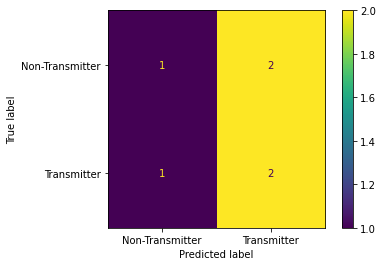

In [20]:
# Plot confusion matrix
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Non-Transmitter","Transmitter"])

In [21]:
# Grid of hyperparameters to search over for hyperparameter optimization
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [22]:
# Optimize hyperparameters using a grid search and then print the optimized hyperparams
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',missing=0,seed=42,use_label_encoder=False,subsample=0.9,colsample_bytree=0.5),
param_grid=param_grid,
scoring='roc_auc',
verbose=1,
n_jobs=10,
cv=3
)
optimal_params.fit(X_train,
           y_train,
           verbose=False,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])
print(optimal_params.best_params_)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}


array([1, 0, 1, 1, 1, 1])

In [24]:
# Rerun classifier with optimized hyperparameters
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            gamma = 0.5,
                            max_depth = 3,
                            scale_pos_weight = 5,
                            min_child_weight = 1,
                            missing=0,subsample=0.8,
                            colsample_bytree=.6,seed=42,use_label_encoder=False)

clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=100,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.60000
[1]	validation_0-aucpr:0.48435
[2]	validation_0-aucpr:0.51790
[3]	validation_0-aucpr:0.43723
[4]	validation_0-aucpr:0.49278
[5]	validation_0-aucpr:0.49278
[6]	validation_0-aucpr:0.40123
[7]	validation_0-aucpr:0.40123
[8]	validation_0-aucpr:0.40123
[9]	validation_0-aucpr:0.40123
[10]	validation_0-aucpr:0.49278
[11]	validation_0-aucpr:0.49278
[12]	validation_0-aucpr:0.54942
[13]	validation_0-aucpr:0.71608
[14]	validation_0-aucpr:0.71608
[15]	validation_0-aucpr:0.71608
[16]	validation_0-aucpr:0.85124
[17]	validation_0-aucpr:0.85124
[18]	validation_0-aucpr:0.85124
[19]	validation_0-aucpr:0.85124
[20]	validation_0-aucpr:0.85124
[21]	validation_0-aucpr:0.71608
[22]	validation_0-aucpr:0.71608
[23]	validation_0-aucpr:0.71608
[24]	validation_0-aucpr:0.71608
[25]	validation_0-aucpr:0.71608
[26]	validation_0-aucpr:0.71608
[27]	validation_0-aucpr:0.71608
[28]	validation_0-aucpr:0.71608
[29]	validation_0-aucpr:0.71608
[30]	validation_0-aucpr:0.71608
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=0, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, seed=42,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

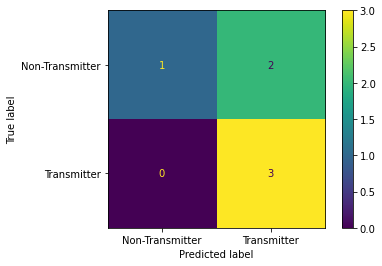

In [25]:
# Plot confusion matrix with updated hyperparams
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Non-Transmitter","Transmitter"])

In [26]:
# Save SHAP values and tree output for visualization
explainer = shap.TreeExplainer(clf_xgb)
shap_values = explainer.shap_values(X)
shap_values_1 = explainer(X)

In [27]:
# Force plot of classification results
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [28]:
# Force explainer plot of classification results
shap.force_plot(explainer.expected_value, shap_values[:,:], X.iloc[:,:])

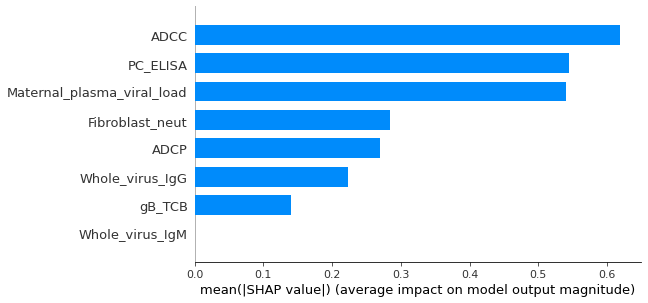

In [29]:
# Summary plot of SHAP values w/o directions
shap.summary_plot(shap_values, X, plot_type="bar")

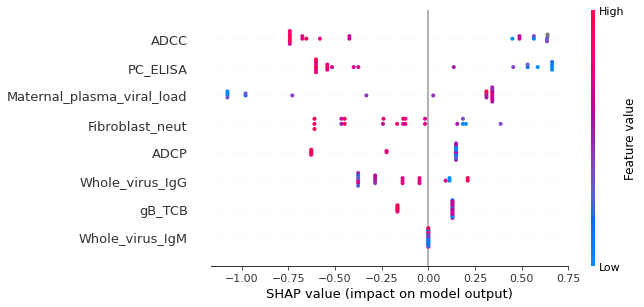

In [30]:
# Summary plot of SHAP values w/o directions
shap.summary_plot(shap_values, X_display)

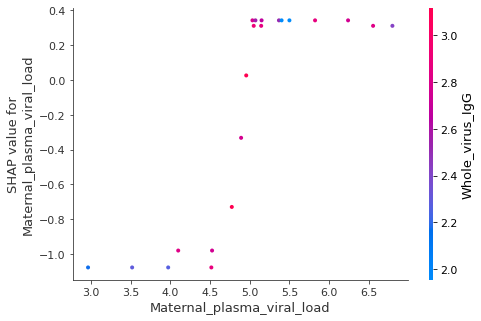

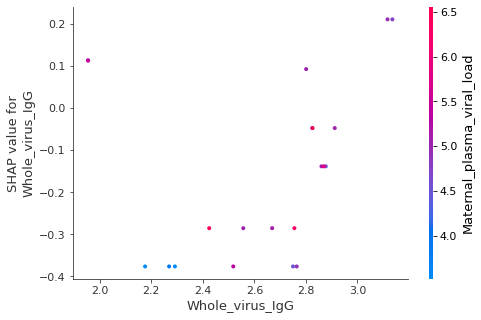

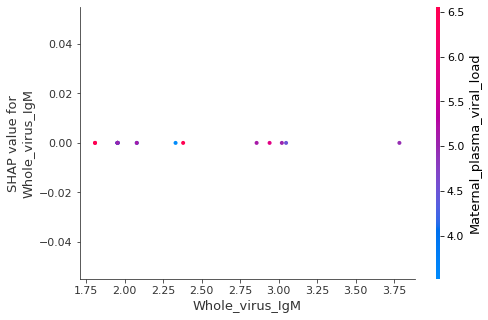

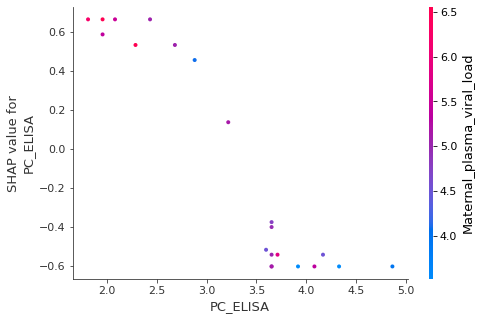

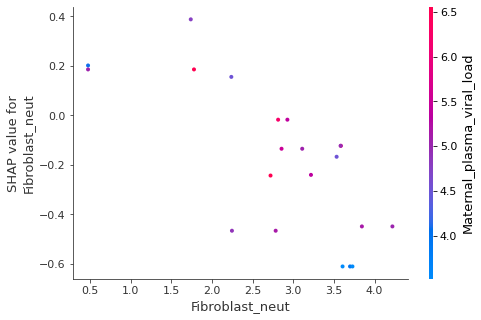

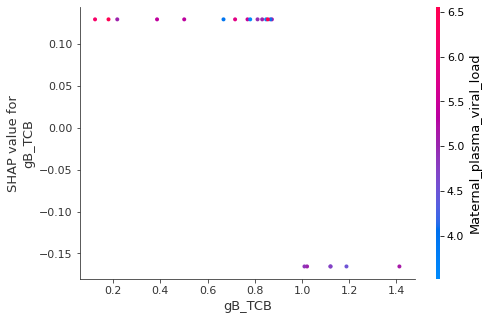

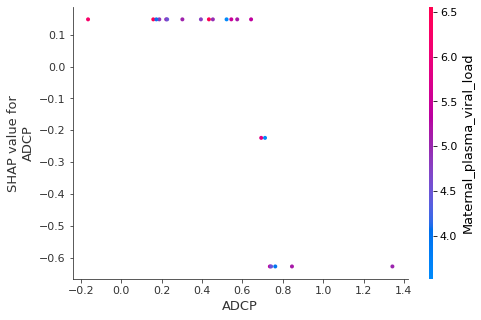

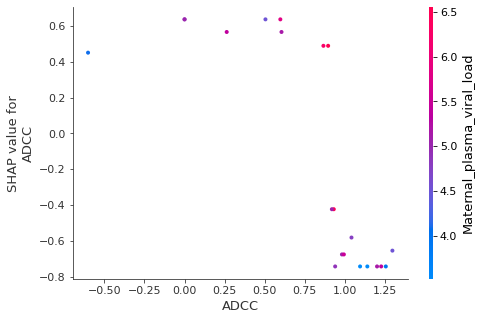

In [31]:
# Feature dependency plots
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

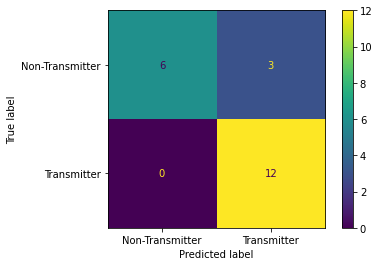

In [32]:
# Plot confusion matrix for entire data set
plot_confusion_matrix(clf_xgb,
                     X,
                     y,
                     values_format='d',
                     display_labels=["Non-Transmitter","Transmitter"])

In [34]:
# Accuracy of initial run
y_pred = clf_xgb.predict(X)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y, predictions)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

Accuracy: 85.714%


ID: GM04 
 Transmission: 1 
 Predicted Transmission: 1


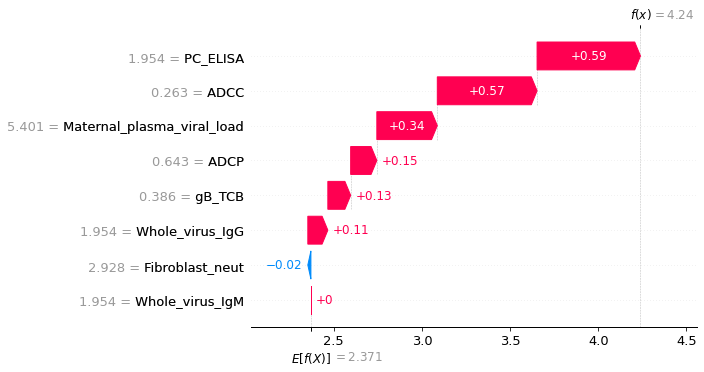

ID: HD79 
 Transmission: 1 
 Predicted Transmission: 1


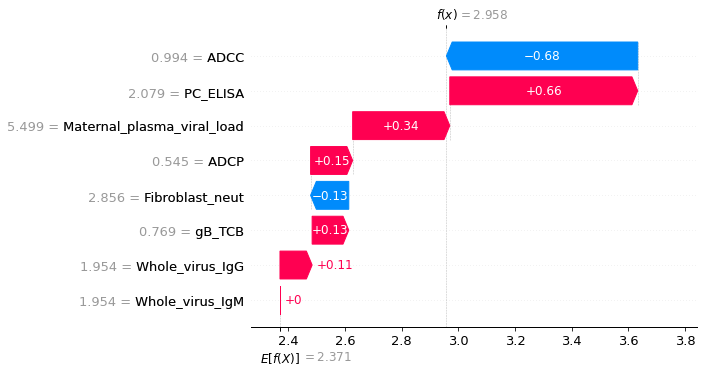

ID: JC65 
 Transmission: 0 
 Predicted Transmission: 1


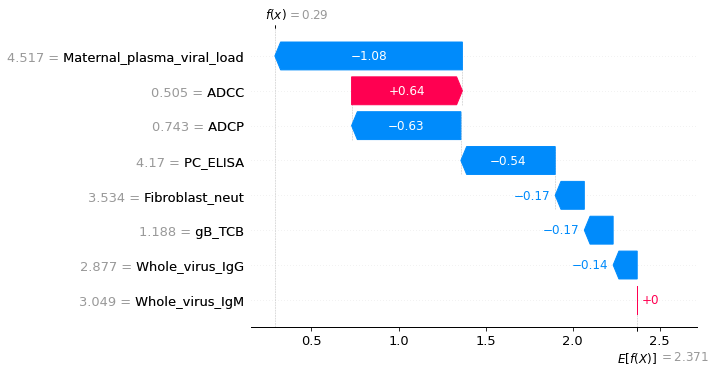

ID: GI73 
 Transmission: 1 
 Predicted Transmission: 1


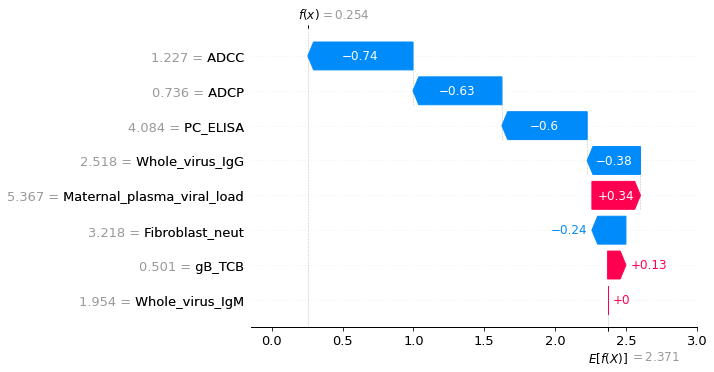

ID: IM67 
 Transmission: 1 
 Predicted Transmission: 1


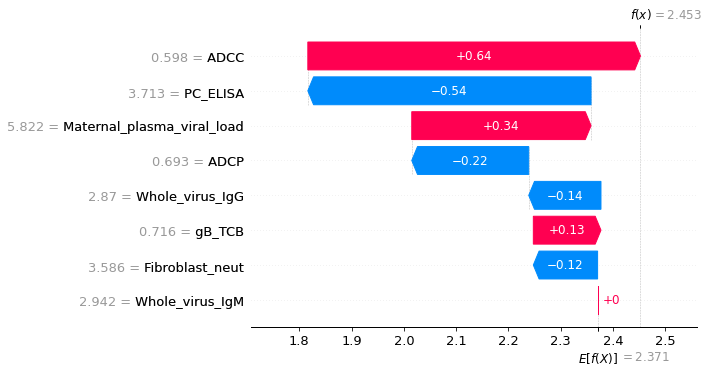

ID: JM52 
 Transmission: 0 
 Predicted Transmission: 0


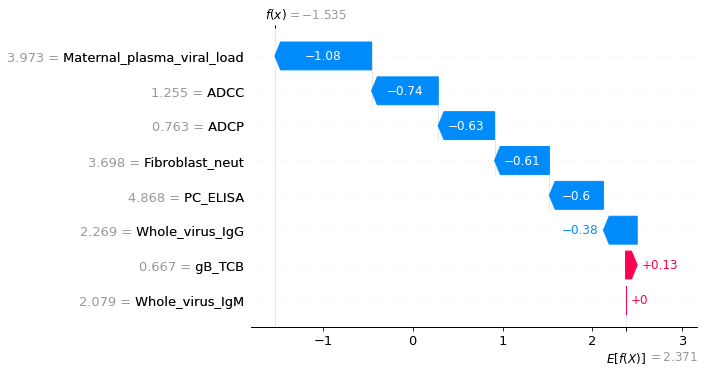

ID: HR73 
 Transmission: 0 
 Predicted Transmission: 0


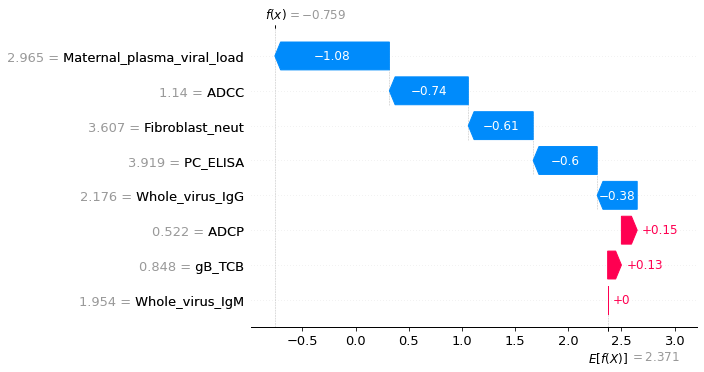

ID: HD82 
 Transmission: 0 
 Predicted Transmission: 0


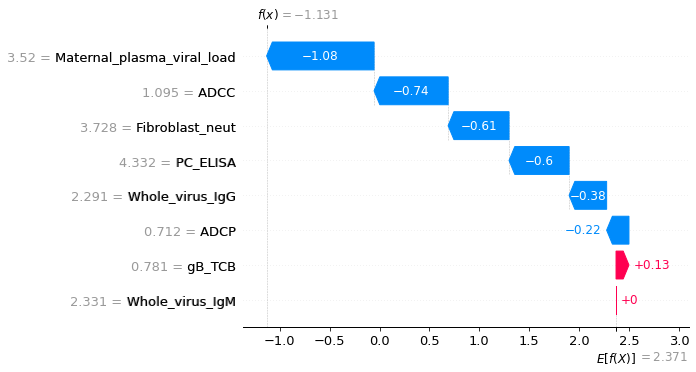

ID: 223-98  
 Transmission: 1 
 Predicted Transmission: 1


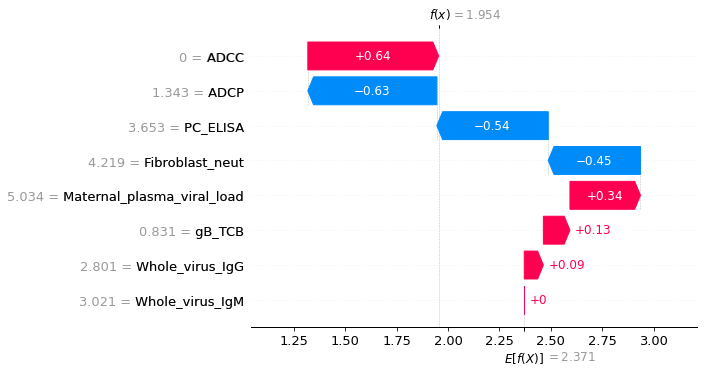

ID: 274-98  
 Transmission: 1 
 Predicted Transmission: 1


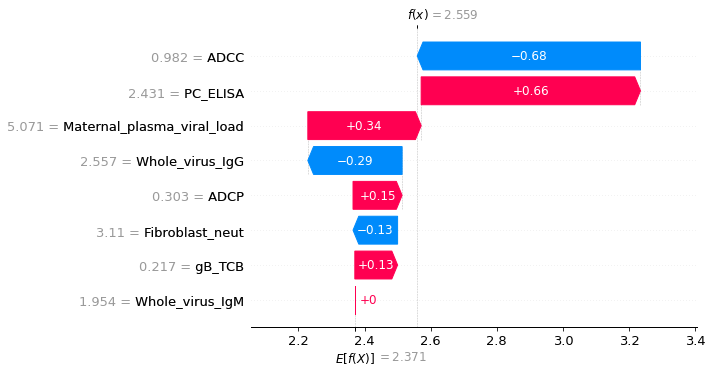

ID: 273-98 
 Transmission: 1 
 Predicted Transmission: 1


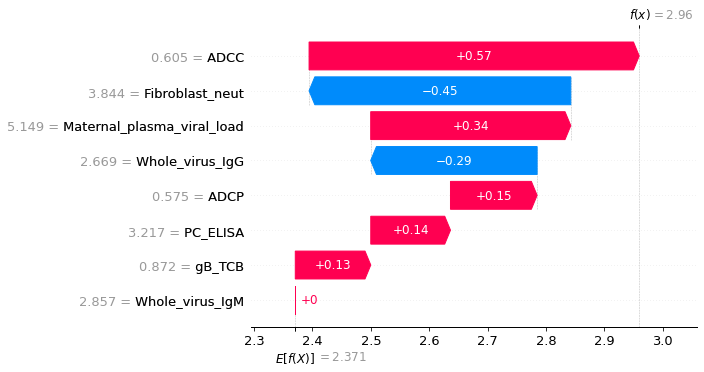

ID: 251-05 
 Transmission: 0 
 Predicted Transmission: 1


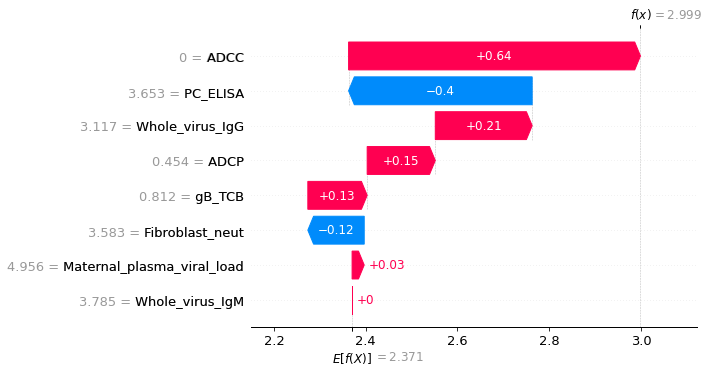

ID: 369-09  
 Transmission: 1 
 Predicted Transmission: 1


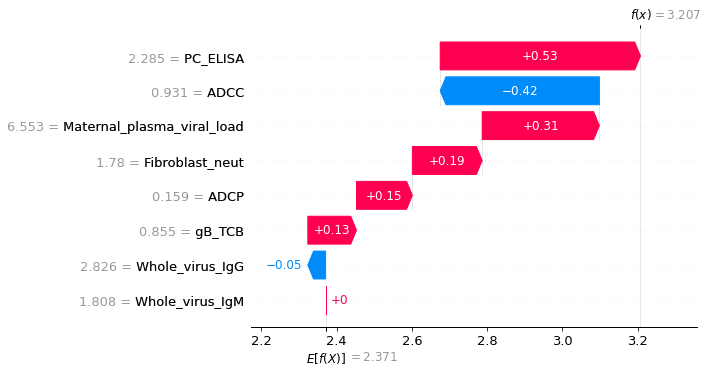

ID: 145-97 
 Transmission: 1 
 Predicted Transmission: 1


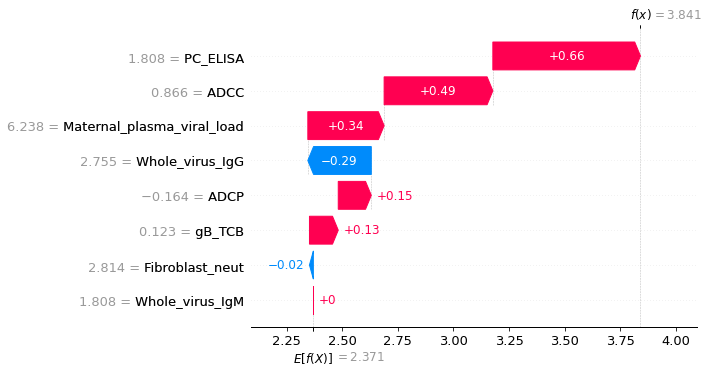

ID: 174-97 
 Transmission: 1 
 Predicted Transmission: 1


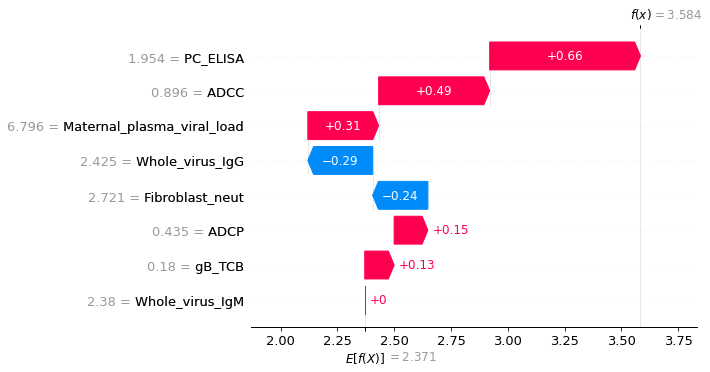

ID: LG94  
 Transmission: 1 
 Predicted Transmission: 1


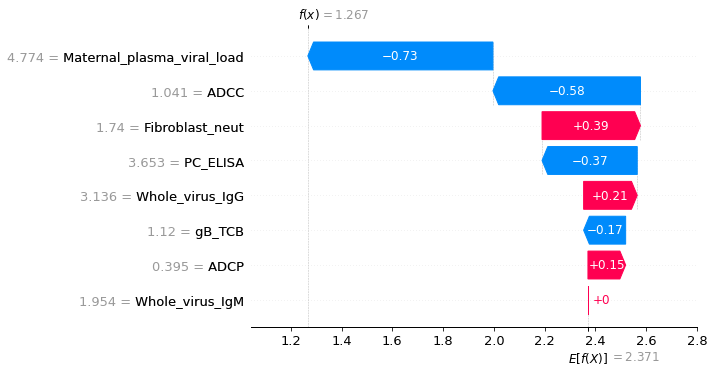

ID: KT47  
 Transmission: 1 
 Predicted Transmission: 1


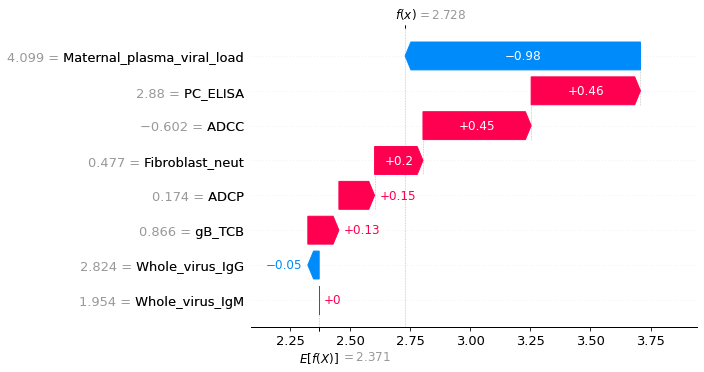

ID: LV43  
 Transmission: 0 
 Predicted Transmission: 0


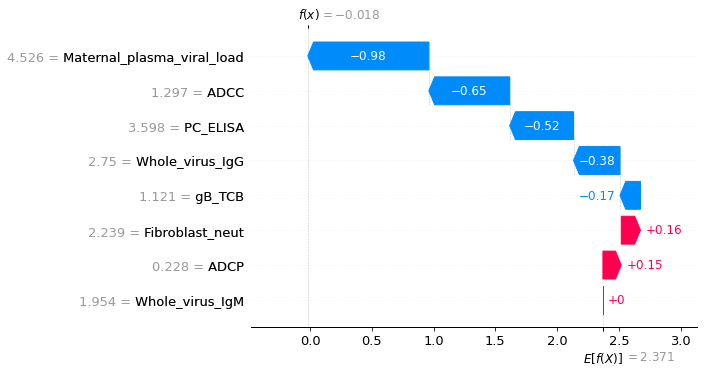

ID: KV61 
 Transmission: 0 
 Predicted Transmission: 1


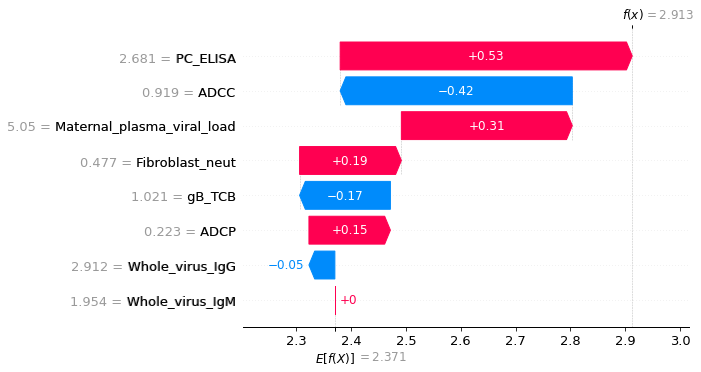

ID: MM18 
 Transmission: 0 
 Predicted Transmission: 0


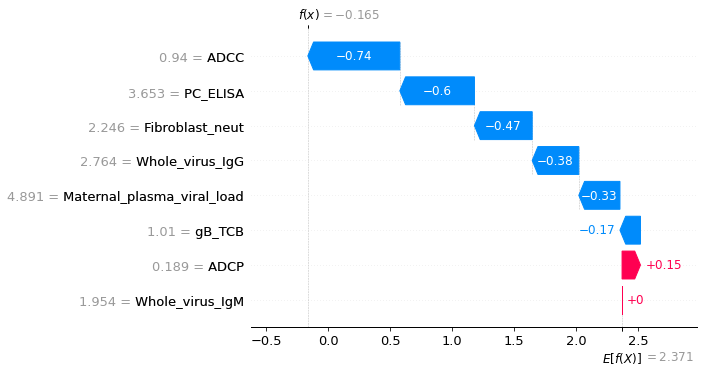

ID: MD59 
 Transmission: 0 
 Predicted Transmission: 0


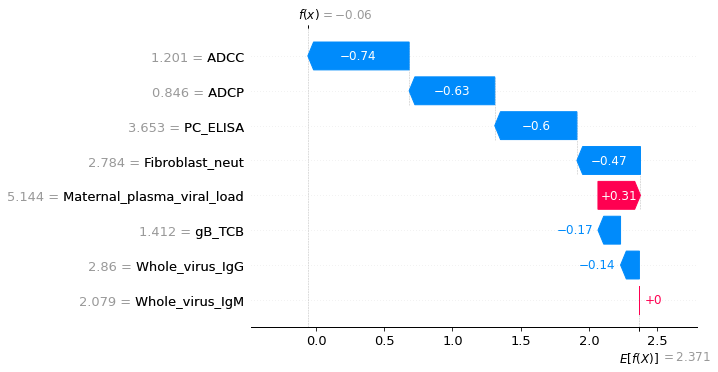

In [36]:
# Print each subject, their classification, their predicted classification, and their waterfall plot for predicted
# transmission status
for index in range(len(df)):
    print('ID:',orig["iD"][index],"\n Transmission:",orig["Transmission_status"][index],"\n Predicted Transmission:",y_pred[index])
    shap.plots.waterfall(shap_values_1[index])

In [37]:
kfold = StratifiedKFold(n_splits=6, random_state=7, shuffle=True)
results = cross_val_score(clf_xgb, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[12:50:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [38]:
for index in range(len(shap_values_1.values)):
    print(shap_values_1.values[index][0])

0.34292644
0.34292644
-1.0768617
0.34292644
0.34292644
-1.0768617
-1.0768617
-1.0768617
0.34292644
0.34292644
0.34292644
0.026436567
0.3115365
0.34292644
0.3115365
-0.72915095
-0.97974557
-0.97974557
0.3115365
-0.33200812
0.3115365


In [41]:
for index in range(len(shap_values_1.values)):
    print(shap_values_1.values[index][3])

0.5863415
0.66349983
-0.5417244
-0.60201275
-0.5417244
-0.60201275
-0.60201275
-0.60201275
-0.5417244
0.66349983
0.13661659
-0.40017307
0.5322993
0.66349983
0.66349983
-0.37498724
0.45514095
-0.5165385
0.5322993
-0.60201275
-0.60201275


In [40]:
for index in range(len(shap_values_1.values)):
    print(shap_values_1.values[index][7])

0.56585443
-0.67534685
0.6362778
-0.7423702
0.6362778
-0.7423702
-0.7423702
-0.7423702
0.6362778
-0.67534685
0.56585443
0.6362778
-0.42306557
0.4886961
0.4886961
-0.5811404
0.45037514
-0.6541428
-0.42306557
-0.7423702
-0.7423702
